# Multi-Class Seizure Classification using WaveNet and BiLSTM on EEG Signals
[Honours Research Project]

@Author: <strong>Stefan Nio</strong>

@Github: <strong>@stefanniouwa</strong> https://github.com/stefanniouwa/SeizureNet

## Abstract
This notebook demonstrates the complete workflow for a multi-class seizure classification task using EEG data and deep learning models—WaveNet and Bidirectional LSTM (BiLSTM). This work is part of an honours research project at the University of Western Australia, aimed to create a deep learning model capable of accurately and robustly classifying multiple seizure types from EEG data, focusing on seven-class patient-wise classification to enhance generalizability. We start with data preprocessing (utilising the [TUSZ Corpus v2.0.3](https://isip.piconepress.com/projects/nedc/html/tuh_eeg/#i_rsyn)), move through model development, and conclude with training, evaluation, and results. For more details, refer to the full dissertation here.

## Table of Contents
1. [Introduction](#Introduction)
2. [Requirements Installation](#Requirements-Installation)
3. [Dataset Overview](#Dataset-Overview)
4. [Dataset Preparation](#Dataset-Preparation)
5. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
   1. [Class Distribution](#Class-Distribution)
   2. [Segment Visualization](#Segment-Visualization)
6. [WaveNet and BiLSTM Model Building](#Model-Building)
7. [Model Training](#Model-Training)
9. [Model Results](#Model-Results)
   1. [Accuracy vs Loss Plot Graph](#Graph)
   2. [Confusion Matrices](#CM)
11. [Conclusions](#Conclusions)

<a id='Introduction'></a>
## 1. Introduction
In this research, we aim to classify seizure types using EEG data from the TUH Seizure Corpus. We leverage deep learning models, specifically <strong>WaveNet</strong> and <strong>BiLSTM</strong>, for multi-class classification. Unlike previous research that focuses extensively on seizure-wise classification, we aim to focus on maximisng <strong>patient-independent results</strong>, which are crucial for real-world applications. We also focus on an end-to-end approach using raw EEG data without feature extraction, making the solution more generalizable and less reliant on domain-specific knowledge. Furthermore, we utilize the most updated dataset <strong>TUSZ version 2.0.3</strong>, setting a benchmark as the first to use this dataset in such a manner. This notebook presents a structured approach, from preprocessing to model evaluation.

<a id='Requirements-Installation'></a>
## 2. Requirements Installation

The necessary libraries for preprocessing step

In [ ]:
import os
import pandas as pd
import numpy as np
import pyedflib
import time
import pickle
import matplotlib.pyplot as plt

<a id='Dataset-Overview'></a>
## 3. Dataset Overview
In this section, we explore the dataset structure, including the number of patients per class, total duration (seconds) per class, and number of seizure event per class. We use system commands to navigate through the directories and extract relevant information.

The TUSZ dataset has a directory structure like so: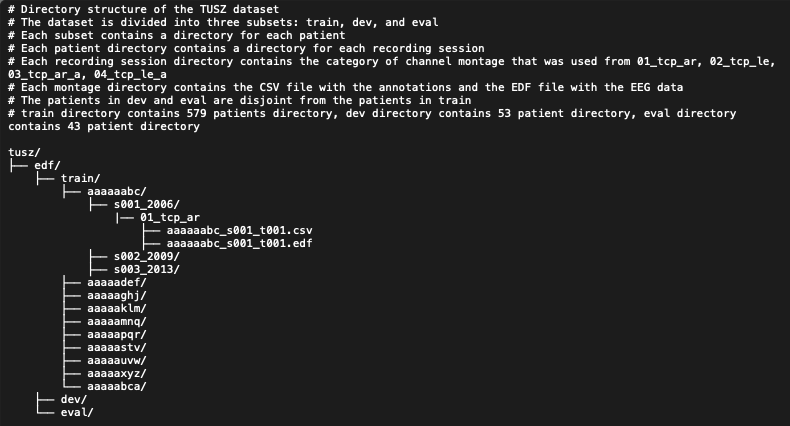

```python
# import os
import glob
import subprocess

# Define the base directory of your dataset
base_dir = "/Users/stefn/cits4010/tusz/edf"
SEIZURE_CLASSES = ['fnsz', 'gnsz', 'cpsz', 'absz', 'tnsz', 'tcsz', 'spsz', 'mysz']


# Function to run shell commands and capture the output
def run_command(cmd):
    return subprocess.getoutput(cmd)

# (11) Total number of seizure events per seizure type:
print("No. of Seizure Events")
for seizure_type in SEIZURE_CLASSES:
    cmd = f"find {base_dir} -name '*.csv' -exec grep -H {seizure_type} {{}} \; | wc -l"
    print(f"{seizure_type}: {run_command(cmd)} ")

# (12) Total duration of seizure events per seizure type:
print("Duration(s)")
for seizure_type in SEIZURE_CLASSES:
    cmd = f"find {base_dir} -name '*.csv' -exec grep -H '{seizure_type},' {{}} \; | cut -d',' -f2,3 | sed -e 's/,/ /g' | awk '{{ sum +=($2-$1)}} END {{print sum}}'"
    print(f"{seizure_type}: {run_command(cmd)} ")

# (13) Number of patients with specific seizure type:
print("No. of Patients")
for seizure_type in SEIZURE_CLASSES:
    cmd = f"find {base_dir} -name '*.csv' -exec grep -H '{seizure_type},' {{}} \; | cut -d'/' -f8 | sort -u | wc -l"
    print(f"{seizure_type}: {run_command(cmd)} ")


    OUTPUT:
No. of Seizure Events
fnsz:    18958 
gnsz:    23717 
cpsz:     3597 
absz:     2508 
tnsz:      410 
tcsz:      857 
spsz:      942 
mysz:       44 

Duration(s)
fnsz: 1.07876e+06 
gnsz: 1.82219e+06 
cpsz: 281774 
absz: 19702.6 
tnsz: 11485 
tcsz: 63739.1 
spsz: 31985.1 
mysz: 28443.2 

No. of Patients
fnsz:      186 
gnsz:      120 
cpsz:       39 
absz:       11 
tnsz:        4 
tcsz:       15 
spsz:        2 
mysz:        1 
```



<a id='Dataset-Preparation'></a>
## 4. Dataset Preparation

This section explains how the TUSZ version 2.0.3 is preprocessed. 

Firstly, define directory path where the downloaded TUSZ directory is. For this research we will be using 7-class seizure types as defined below

In [2]:
# Directories and Event Classes
TUSZ_DIR = "/Users/stefn/cits4010/tusz/edf"       # change this to match your folder structure
EVENT_CLASSES = ['fnsz', 'gnsz', 'spsz', 'cpsz', 'absz', 'tnsz', 'tcsz']

### Let's explore the csv and edf file content

In [3]:
# Define a function to print out the contents of an EDF file
def print_edf_contents(edf_file_path):
    try:
        f = pyedflib.EdfReader(edf_file_path)
        num_signals = f.signals_in_file
        signal_labels = f.getSignalLabels()
        print(f"Number of Signals: {num_signals}")
        print("Signal Labels:", signal_labels)
        for i in range(num_signals):
            print(f"Signal {i+1} ({signal_labels[i]}):")
            print(f.readSignal(i)[:10])  # Print first 10 values of each signal to show user
    finally:
        f.close()

# Define a function to print out the contents of a CSV file
def print_csv_contents(csv_file_path):
    try:
        df = pd.read_csv(csv_file_path, sep=",", comment='#', skip_blank_lines=True)
        print("\nCSV File Contents:")
        print(df.head(10))  # Print the first 5 rows to show user
    except pd.errors.ParserError as e:
        print(f"ParserError for CSV file {csv_file_path}: {e}")
    except Exception as e:
        print(f"Error reading CSV file {csv_file_path}: {e}")

# Example usage
print_edf_contents("/Users/stefn/cits4010/tusz/edf/train/aaaaalpn/s002_2014/01_tcp_ar/aaaaalpn_s002_t001.edf")
print_csv_contents("/Users/stefn/cits4010/tusz/edf/train/aaaaalpn/s002_2014/01_tcp_ar/aaaaalpn_s002_t001.csv")

Number of Signals: 31
Signal Labels: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG C3P-REF', 'EEG C4P-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG 31-REF', 'EEG 32-REF', 'IBI', 'BURSTS', 'SUPPR']
Signal 1 (EEG FP1-REF):
[-2.84028932 -0.49793341 -4.01146727 -6.52113431 -3.676845   -0.33062227
 -2.00373363 -5.68457863 -4.34608954 -0.33062227]
Signal 2 (EEG FP2-REF):
[-7.69231227 -7.35768999 -7.69231227 -7.52500113 -6.68844545 -6.52113431
 -7.19037886 -7.35768999 -7.02306772 -6.85575658]
Signal 3 (EEG F3-REF):
[-12.04240181  -9.86735704 -13.21357976 -15.55593567 -13.54820203
 -10.36929044 -11.37315726 -14.88669112 -13.8828243  -10.20197931]
Signal 4 (EEG F4-REF):
[-12.71164635 -12.87895749 -13.71551317 -13.8828243  -13.54820203

There's a slight difference on how the csv file and the edf file allocate the channel mappings. Hence, we should map these channels accordingly. In our research, we utilise the standard international 10-20 system electrode placement map and is defined as follows (as per TUSZ v2.0.3 DOCS):
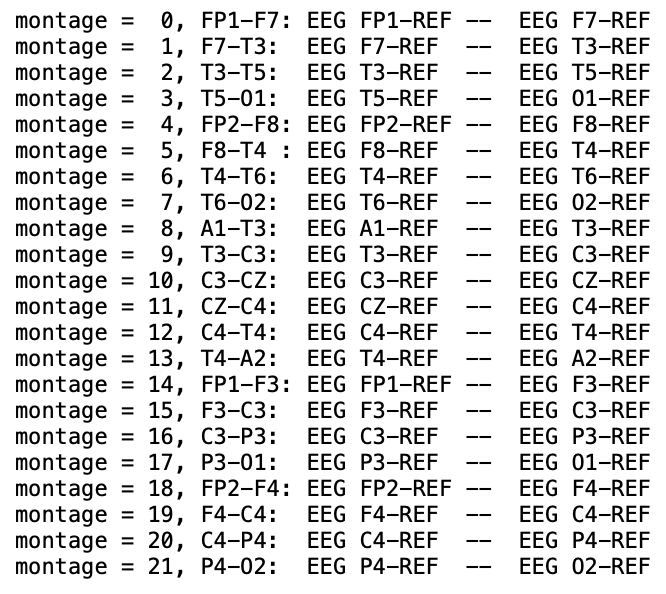

For example, channel 1 is a difference between electrodes F7 and T3,
and represents an arithmetic difference of the channels
(F7-REF)-(T3-REF), which are channels contained in the EDF file. 

Another thing to note is that there are 4 categories of the channel configurations; being 01_tcp_ar, 02_tcp_le, 03_tcp_ar_a, 04_tcp_le_a.
Files contained in 02_tcp_le and 04_tcp_le_a montages will have '-LE' instead of '-REF' for each EEG electrode name

This is how we can map the two:

In [4]:
# Mapping from standard montage to EDF file channels for both -REF and -LE
MONTAGE_MAP_REF = {
    'FP1-F7': ('EEG FP1-REF', 'EEG F7-REF'),
    'F7-T3': ('EEG F7-REF', 'EEG T3-REF'),
    'T3-T5': ('EEG T3-REF', 'EEG T5-REF'),
    'T5-O1': ('EEG T5-REF', 'EEG O1-REF'),
    'FP2-F8': ('EEG FP2-REF', 'EEG F8-REF'),
    'F8-T4': ('EEG F8-REF', 'EEG T4-REF'),
    'T4-T6': ('EEG T4-REF', 'EEG T6-REF'),
    'T6-O2': ('EEG T6-REF', 'EEG O2-REF'),
    'A1-T3': ('EEG A1-REF', 'EEG T3-REF'),
    'T3-C3': ('EEG T3-REF', 'EEG C3-REF'),
    'C3-CZ': ('EEG C3-REF', 'EEG CZ-REF'),
    'CZ-C4': ('EEG CZ-REF', 'EEG C4-REF'),
    'C4-T4': ('EEG C4-REF', 'EEG T4-REF'),
    'T4-A2': ('EEG T4-REF', 'EEG A2-REF'),
    'FP1-F3': ('EEG FP1-REF', 'EEG F3-REF'),
    'F3-C3': ('EEG F3-REF', 'EEG C3-REF'),
    'C3-P3': ('EEG C3-REF', 'EEG P3-REF'),
    'P3-O1': ('EEG P3-REF', 'EEG O1-REF'),
    'FP2-F4': ('EEG FP2-REF', 'EEG F4-REF'),
    'F4-C4': ('EEG F4-REF', 'EEG C4-REF'),
    'C4-P4': ('EEG C4-REF', 'EEG P4-REF'),
    'P4-O2': ('EEG P4-REF', 'EEG O2-REF')
}

MONTAGE_MAP_LE = {
    'FP1-F7': ('EEG FP1-LE', 'EEG F7-LE'),
    'F7-T3': ('EEG F7-LE', 'EEG T3-LE'),
    'T3-T5': ('EEG T3-LE', 'EEG T5-LE'),
    'T5-O1': ('EEG T5-LE', 'EEG O1-LE'),
    'FP2-F8': ('EEG FP2-LE', 'EEG F8-LE'),
    'F8-T4': ('EEG F8-LE', 'EEG T4-LE'),
    'T4-T6': ('EEG T4-LE', 'EEG T6-LE'),
    'T6-O2': ('EEG T6-LE', 'EEG O2-LE'),
    'A1-T3': ('EEG A1-LE', 'EEG T3-LE'),
    'T3-C3': ('EEG T3-LE', 'EEG C3-LE'),
    'C3-CZ': ('EEG C3-LE', 'EEG CZ-LE'),
    'CZ-C4': ('EEG CZ-LE', 'EEG C4-LE'),
    'C4-T4': ('EEG C4-LE', 'EEG T4-LE'),
    'T4-A2': ('EEG T4-LE', 'EEG A2-LE'),
    'FP1-F3': ('EEG FP1-LE', 'EEG F3-LE'),
    'F3-C3': ('EEG F3-LE', 'EEG C3-LE'),
    'C3-P3': ('EEG C3-LE', 'EEG P3-LE'),
    'P3-O1': ('EEG P3-LE', 'EEG O1-LE'),
    'FP2-F4': ('EEG FP2-LE', 'EEG F4-LE'),
    'F4-C4': ('EEG F4-LE', 'EEG C4-LE'),
    'C4-P4': ('EEG C4-LE', 'EEG P4-LE'),
    'P4-O2': ('EEG P4-LE', 'EEG O2-LE')
}

Next, we create a function that extracts annotated seizure events from <code>.csv</code> file and returns a filtered DataFrame where it takes start_time, stop_time, channel, and label columns. The <code>.csv_bi</code> files we ignore in this research as that is designed more for doing binary classification of seizure/non-seizure 

In [5]:
def parse_csv_annotations(csv_file):
    """
    Extracts seizure event annotations from a .csv file.
    """
    try:
        df = pd.read_csv(csv_file, sep=",", comment='#', skip_blank_lines=True)
        df.columns = ['channel', 'start_time', 'stop_time', 'label', 'confidence']
        df = df[['start_time', 'stop_time', 'channel', 'label']]  # Keep relevant columns
        return df[df['label'].isin(EVENT_CLASSES)]
    except pd.errors.ParserError as e:
        print(f"ParserError for file {csv_file}: {e}")
        return pd.DataFrame()
    except ValueError as ve:
        print(f"ValueError for file {csv_file}: {ve}")
        return pd.DataFrame()

We need a function to calculate the signal difference between the two electrodes to match the mappings

In [6]:
def get_signal_difference(f, ch1, ch2, start, stop):
    """
    Computes the difference between two EEG channels.
    """
    signal1 = f.readSignal(ch1)[start:stop]
    signal2 = f.readSignal(ch2)[start:stop]
    return signal1 - signal2

Next, we will load EEG data off the <code>.edf</code> file based on the annotations from the <code>.csv</code>. Iterate over each montage pair to get channel differences as segments, then store segment with its label in a list.

In [7]:
def load_eeg_with_annotations(edf_file, annotations, montage_map, num_timesteps=256):
    """
    Loads EEG data corresponding to annotated events.
    """
    segments = []
    try:
        start_time = time.time()
        f = pyedflib.EdfReader(edf_file)
        channel_labels = f.getSignalLabels()
        sample_freq = f.getSampleFrequency(0)
        print("Channels:", channel_labels)
        print("Sample Frequency:", sample_freq)
        print("EDF Reading Time:", time.time() - start_time)

        for _, row in annotations.iterrows():
            start = int(row['start_time'] * sample_freq)
            stop = int(row['stop_time'] * sample_freq)
            signal = np.zeros((len(montage_map), num_timesteps))

            annotation_start_time = time.time()
            for idx, (montage, (ch1, ch2)) in enumerate(montage_map.items()):
                if ch1 in channel_labels and ch2 in channel_labels:
                    ch1_index = channel_labels.index(ch1)
                    ch2_index = channel_labels.index(ch2)
                    channel_signal = get_signal_difference(f, ch1_index, ch2_index, start, stop)

                    # Ensure the channel_signal is exactly num_timesteps long
                    if len(channel_signal) < num_timesteps:
                        # Pad the signal if it is shorter
                        padded_signal = np.pad(channel_signal, (0, num_timesteps - len(channel_signal)), 'constant')
                        signal[idx, :] = padded_signal
                    else:
                        # Truncate the signal if it is longer
                        signal[idx, :] = channel_signal[:num_timesteps]
                else:
                    print(f"Channels {ch1} or {ch2} not found in EDF file.")
            print("Annotation Processing Time:", time.time() - annotation_start_time)

            segments.append((signal, row['label']))
    except Exception as e:
        print(f"Error loading EDF file {edf_file}: {e}")
    finally:
        if 'f' in locals():
            f.close()

    return segments

Then, normalize the segments

In [8]:
def preprocess_segments(segments):
    """
    Preprocess EEG segments: normalize and pad/truncate.
    """
    preprocessed_segments = []
    for signal, event in segments:
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)
        std[std == 0] = 1  # Avoid division by zero
        normalized_signal = (signal - mean) / std
        preprocessed_segments.append((normalized_signal, event))
    return preprocessed_segments

This is a huge data codebase. Before looping through the directories, we create a checkpoint mechanism to save and load the preprocesing steps in case the jupyter kernel fails.

In [9]:
def save_checkpoint(data, filename):
    """
    Save checkpoint data to a file atomically.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    # Use a temporary filename for atomic save
    temp_filename = filename + '.tmp'
    with open(temp_filename, 'wb') as f:
        pickle.dump(data, f)
    os.rename(temp_filename, filename)

def load_checkpoint(filename):
    """
    Load checkpoint data from a file with error handling.
    """
    if os.path.exists(filename):
        try:
            with open(filename, 'rb') as f:
                return pickle.load(f)
        except (EOFError, pickle.UnpicklingError) as e:
            print(f"Error loading checkpoint {filename}: {e}")
            return None
    return None

Our main function that goes through each subdirectories to preprocess our data and EEG segments. This function considers if a checkpoint exists, iterates over subdirectories to find <code>.edf</code> files based on its corresponding signal timing <code>.csv</code> fies. Determine which montage channel mapping to use based on the montage channel category. Returns the list of all preprocessed EEG segments

In [10]:
def load_and_preprocess_all_segments(directory, num_timesteps=256, checkpoint_dir='checkpoints'):
    """
    Load and preprocess all EEG segments from all subdirectories with checkpointing.
    """
    all_segments = []
    processed_patients = set()
    
    # Load checkpoint if exists
    checkpoint_file = os.path.join(checkpoint_dir, 'all_segments.pkl')
    checkpoint_data = load_checkpoint(checkpoint_file)
    if checkpoint_data is not None:
        all_segments, processed_patients = checkpoint_data

    for root, _, files in os.walk(directory):
        edf_files = [f for f in files if f.endswith('.edf')]
        for edf_file in edf_files:
            base_name = edf_file[:-4]
            csv_file = os.path.join(root, base_name + '.csv')
            if os.path.exists(csv_file) and base_name not in processed_patients:
                annotations = parse_csv_annotations(csv_file)
                edf_path = os.path.join(root, edf_file)
                
                # Determine montage type based on directory structure
                if '02_tcp_le' in root:
                    montage_map = MONTAGE_MAP_LE
                elif '03_tcp_ar_a' in root:
                    montage_map = {k: v for k, v in MONTAGE_MAP_REF.items() if 'EEG A1-REF' not in v and 'EEG A2-REF' not in v}
                else:
                    montage_map = MONTAGE_MAP_REF
                
                segments = load_eeg_with_annotations(edf_path, annotations, montage_map, num_timesteps)
                preprocessed_segments = preprocess_segments(segments)
                all_segments.extend(preprocessed_segments)
                processed_patients.add(base_name)
                
                # Save checkpoint after processing each patient
                save_checkpoint((all_segments, processed_patients), checkpoint_file)

    print(f"Processed {len(processed_patients)} patients from directory {directory}")
    return all_segments

Ensure that checkpoint exists

In [11]:
# Ensure checkpoint directory exists
os.makedirs('checkpoints/train', exist_ok=True)
os.makedirs('checkpoints/dev', exist_ok=True)
os.makedirs('checkpoints/eval', exist_ok=True)

We then create a function that prepares each directory segments list to be our X and Y numpy arrays for our deep learning. We check for expected format in this step.

In [12]:
def prepare_data(segments):
    """
    Prepares data and labels for deep learning.
    """
    X = []
    y = []
    label_map = {event: idx for idx, event in enumerate(EVENT_CLASSES)}
    for segment in segments:
        if len(segment) == 2:
            signal, event = segment
        else:
            print(f"Unexpected segment format: {segment}")
            continue

        # Check if the signal shape is consistent with expected shape (22 channels, 256 timesteps)
        if signal.shape != (22, 256):
            #print(f"Inconsistent signal shape detected: {signal.shape}")
            continue  # Skip this signal if the shape is inconsistent

        X.append(signal)
        y.append(label_map[event])
    
    return np.array(X), np.array(y)

Execute our preprocessing step (CAUTION: Long runtime), check for our X and Y shape

In [13]:
# Load and preprocess datasets with checkpointing
train_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/train', checkpoint_dir='checkpoints/train')
dev_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/dev', checkpoint_dir='checkpoints/dev')
eval_segments = load_and_preprocess_all_segments(TUSZ_DIR + '/eval', checkpoint_dir='checkpoints/eval')

# Prepare datasets
X_train, y_train = prepare_data(train_segments)
X_dev, y_dev = prepare_data(dev_segments)
X_eval, y_eval = prepare_data(eval_segments)

# Example output shapes
print("Training Data:", X_train.shape, y_train.shape)
print("Development Data:", X_dev.shape, y_dev.shape)
print("Evaluation Data:", X_eval.shape, y_eval.shape)

Processed 4664 patients from directory /Users/stefn/cits4010/tusz/edf/train
Processed 1832 patients from directory /Users/stefn/cits4010/tusz/edf/dev
Processed 868 patients from directory /Users/stefn/cits4010/tusz/edf/eval
Training Data: (19467, 22, 256) (19467,)
Development Data: (15895, 22, 256) (15895,)
Evaluation Data: (6739, 22, 256) (6739,)


<a id='Exploratory-Data-Analysis'></a>
## 5. Exploratory Data Analysis (EDA)

<a id='Class-Distribution'></a>
### A. Class Distribution 

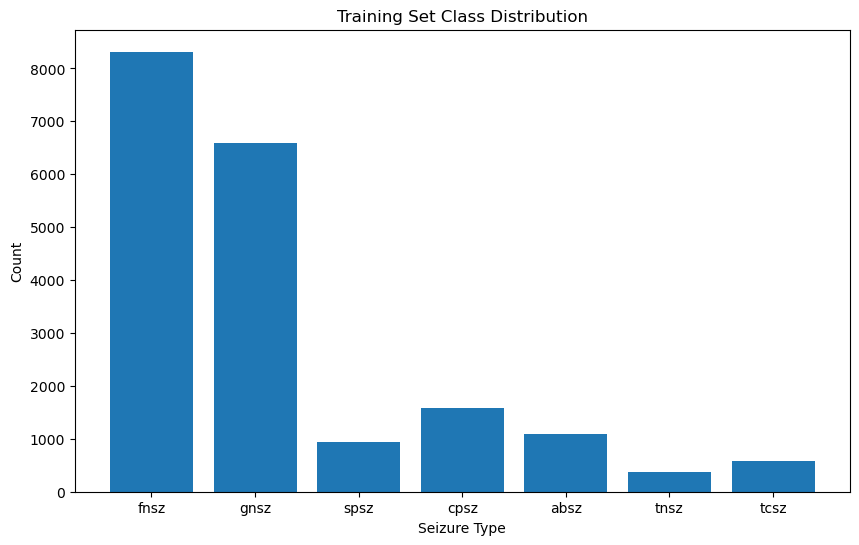

In [14]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 6))
    plt.bar([EVENT_CLASSES[i] for i in unique], counts)
    plt.title(title)
    plt.xlabel('Seizure Type')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(y_train, 'Training Set Class Distribution')


<a id='Segment-Visualization'></a>
### B. Segment Visualization

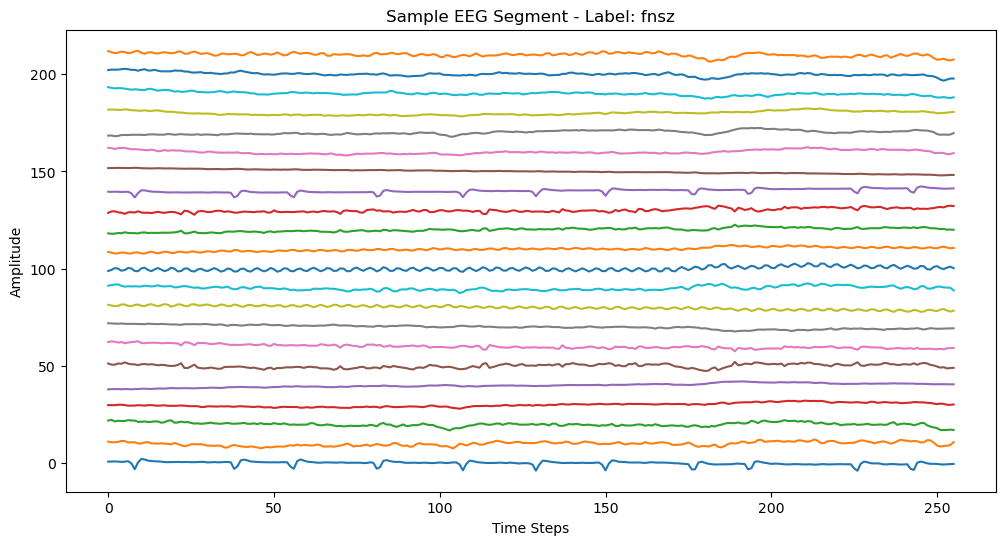

In [15]:
def plot_sample_signal(X, y, index):
    plt.figure(figsize=(12, 6))
    for i in range(22):  # Assuming 22 channels
        plt.plot(X[index, i, :] + i*10)  # Offset each channel for visualization
    plt.title(f'Sample EEG Segment - Label: {EVENT_CLASSES[y[index]]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Amplitude')
    plt.show()

plot_sample_signal(X_train, y_train, index=16456)


<a id='Model-Building'></a>
### 6. Model Building 

Let's import the necessary libraries to build our model, we are using Keras

In [16]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import (
    Layer, Input, Conv1D, Multiply, Add, Dense, Dropout,
    AveragePooling1D, Flatten, Bidirectional, LSTM, BatchNormalization,
    concatenate, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import StratifiedKFold


### Overview of Functions and Models

More details in paper.

<strong>wavenet_layer</strong>: Applies dilated convolutions for feature extraction with residual connections.

<strong>ChannelWiseAttention</strong>: Custom layer to focus on important channels using attention weights.

<strong>build_wavenet_model</strong>: Creates a WaveNet model with multiple stacked WaveNet layers for feature extraction.

<strong>build_bilstm_model</strong>: Constructs a bidirectional LSTM model for sequence learning.

<strong>build_bilstm_attention_model</strong>: Builds a BiLSTM model with channel-wise attention to focus on key channels.

<strong>build_wavenet_bilstm_attention_model</strong>: Combines WaveNet and BiLSTM paths with attention, then concatenates features for classification.

<strong>calculate_per_class_metrics</strong>: Computes per-class sensitivity and specificity using confusion matrix values.

In [17]:
# WaveNet Layer
def wavenet_layer(x, filters, kernel_size, dilation_rates, l2_reg=0.01):
    x = Conv1D(filters=filters, kernel_size=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters=filters, kernel_size=kernel_size, 
                          padding='same', activation='tanh', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(x)
        sigm_out = Conv1D(filters=filters, kernel_size=kernel_size, 
                          padding='same', activation='sigmoid', dilation_rate=dilation_rate, kernel_regularizer=l2(l2_reg))(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters=filters, kernel_size=1, padding='same', kernel_regularizer=l2(l2_reg))(x)
        res_x = Add()([res_x, x])
    return res_x

# Define Channel-Wise Attention Layer
class ChannelWiseAttention(Layer):
    def __init__(self, **kwargs):
        super(ChannelWiseAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.attention_dense = Dense(1, activation='tanh')
        super(ChannelWiseAttention, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch_size, num_channels, hidden_dim)
        attention_scores = self.attention_dense(inputs)  # (batch_size, num_channels, 1)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)  # (batch_size, num_channels, 1)
        output = tf.reduce_sum(inputs * attention_weights, axis=1)  # (batch_size, hidden_dim)
        return output

# WaveNet Model
def build_wavenet_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = wavenet_layer(inp, filters=16, kernel_size=3, dilation_rates=[1, 2, 4, 8])
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = wavenet_layer(x, filters=32, kernel_size=3, dilation_rates=[1, 2, 4])
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = wavenet_layer(x, filters=64, kernel_size=3, dilation_rates=[1, 2])
    x = BatchNormalization()(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    return model

# BiLSTM Model
def build_bilstm_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    return model

# BiLSTM with Attention Model
def build_bilstm_attention_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x = ChannelWiseAttention()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    return model

# WaveNet-BiLSTM Model
def build_wavenet_bilstm_attention_model(input_shape, num_classes):
    inp = Input(shape=input_shape)
    # WaveNet Path
    x1 = wavenet_layer(inp, filters=16, kernel_size=3, dilation_rates=[1, 2, 4, 8])
    x1 = BatchNormalization()(x1)
    x1 = AveragePooling1D(pool_size=2)(x1)
    x1 = wavenet_layer(x1, filters=32, kernel_size=3, dilation_rates=[1, 2, 4])
    x1 = BatchNormalization()(x1)
    x1 = AveragePooling1D(pool_size=2)(x1)
    x1 = wavenet_layer(x1, filters=64, kernel_size=3, dilation_rates=[1, 2])
    x1 = BatchNormalization()(x1)
    x1 = AveragePooling1D(pool_size=2)(x1)
    x1 = GlobalAveragePooling1D()(x1)
    # BiLSTM Path
    x2 = Bidirectional(LSTM(64, return_sequences=True))(inp)
    x2 = ChannelWiseAttention()(x2)
    x2 = Dropout(0.5)(x2)
    # Concatenate Paths
    concatenated = concatenate([x1, x2])
    x = Dropout(0.5)(concatenated)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)
    return model

# Function to calculate per-class sensitivity and specificity
def calculate_per_class_metrics(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    TN = np.sum(cm) - (FP + FN + TP)

    # Handle division by zero
    sensitivity = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP + FN)!=0)
    specificity = np.divide(TN, TN + FP, out=np.zeros_like(TN, dtype=float), where=(TN + FP)!=0)
    return sensitivity, specificity

Before we feed in the raw EEG signal input, make sure the input shape is what's expected of the models; ie <code>(samples, timesteps, channels)</code>. For multi-class classification, we convert the labels into one-hot encoding.

In [18]:
# Data Preparation Function
def prepare_input_data(X):
    return np.transpose(X, (0, 2, 1))  # Transpose to (num_samples, timesteps, channels)

# Prepare Data
X_train_prepared = prepare_input_data(X_train)
X_dev_prepared = prepare_input_data(X_dev)
X_eval_prepared = prepare_input_data(X_eval)

# One-Hot Encoding of Labels
num_classes = len(EVENT_CLASSES)
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_dev_onehot = to_categorical(y_dev, num_classes=num_classes)
y_eval_onehot = to_categorical(y_eval, num_classes=num_classes)


### Performance metrics evaluation

In this research, we are employing two evaluation techniques.
1. Seizure-wise cross-validation
2. Patient-wise cross-validation

Model training parameters are made equal for both techniques, namely:
1. Batch Size = 32
2. Epochs = 100
3. Regularisation technique: Early stopping with a patience of 10
4. Regularisation technique: Learning Rate callback defined by a step decay function
5. Loss function: Categorical Cross-entropy
6. Optimizer: Adam

Metrics that are calculated:
1. Weighted F1-score
2. Accuracy
3. Precision
4. Recall
5. Sensitivity
6. Specificity
7. Confusion Matrix


In [19]:
def seizure_wise_cross_validation(model_builder, X, y, num_classes, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    f1_scores = []
    accuracies = []
    precisions = []
    recalls = []
    sensitivities = []
    specificities = []
    confusion_matrices = []
    all_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    for fold_index, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Convert y_train_fold and y_test_fold to One-Hot Encoding
        y_train_fold_onehot = to_categorical(y_train_fold, num_classes=num_classes)
        y_test_fold_onehot = to_categorical(y_test_fold, num_classes=num_classes)

        # Create a new model for each fold
        clear_session()
        model = model_builder()
        model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

        # Define callbacks
        lr_decay = LearningRateScheduler(step_decay)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model on the current fold and store the history
        history = model.fit(
            X_train_fold, y_train_fold_onehot,
            epochs=100, batch_size=32,
            validation_data=(X_test_fold, y_test_fold_onehot),
            callbacks=[lr_decay, early_stopping], verbose=1
        )

        # Store metrics for plotting
        for metric in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
            all_history[metric].append(history.history[metric])

        # Predict and calculate metrics
        y_pred = model.predict(X_test_fold)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Metrics
        f1 = f1_score(y_test_fold, y_pred_classes, average='weighted', zero_division=0)
        f1_scores.append(f1)

        accuracy = accuracy_score(y_test_fold, y_pred_classes)
        accuracies.append(accuracy)

        precision = precision_score(y_test_fold, y_pred_classes, average='weighted', zero_division=0)
        precisions.append(precision)

        recall = recall_score(y_test_fold, y_pred_classes, average='weighted', zero_division=0)
        recalls.append(recall)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test_fold, y_pred_classes)
        confusion_matrices.append(conf_matrix)

        # Per-Class Sensitivity and Specificity
        sensitivity_per_class, specificity_per_class = calculate_per_class_metrics(y_test_fold, y_pred_classes, num_classes)
        average_sensitivity = np.nanmean(sensitivity_per_class)
        average_specificity = np.nanmean(specificity_per_class)
        sensitivities.append(average_sensitivity)
        specificities.append(average_specificity)

    # Sum confusion matrices over all folds
    total_cm = np.sum(confusion_matrices, axis=0)

    # Average the metrics across folds
    avg_metrics = {
        'f1_score': np.mean(f1_scores),
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'sensitivity': np.nanmean(sensitivities),
        'specificity': np.nanmean(specificities),
        'confusion_matrix': total_cm 

    }

    # Prepare averaged history
    averaged_history = {}
    for metric in all_history:
        max_len = max(len(hist) for hist in all_history[metric])
        padded_histories = []
        for hist in all_history[metric]:
            if len(hist) < max_len:
                padded_hist = hist + [np.nan]*(max_len - len(hist))
            else:
                padded_hist = hist
            padded_histories.append(padded_hist)
        averaged_history[metric] = np.nanmean(padded_histories, axis=0)

    return avg_metrics, averaged_history


In [20]:
def patient_wise_validation(model_builder, X_train, y_train, X_val, y_val, num_classes):
    clear_session()
    model = model_builder()
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    lr_decay = LearningRateScheduler(step_decay)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100, batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[lr_decay, early_stopping], verbose=1
    )

    # Evaluate on validation data
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Metrics
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted', zero_division=0)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Per-Class Sensitivity and Specificity
    sensitivity_per_class, specificity_per_class = calculate_per_class_metrics(y_true_classes, y_pred_classes, num_classes)
    average_sensitivity = np.nanmean(sensitivity_per_class)
    average_specificity = np.nanmean(specificity_per_class)

    metrics = {
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'sensitivity': average_sensitivity,
        'specificity': average_specificity,
        'confusion_matrix': conf_matrix  

    }

    return metrics, history.history, model


<a id='Model-Training'></a>
## 7. Model Training
This block <strong>executes</strong> the training loop for all our models, ensuring we are running the validation techniques on all models. We save these history and metrics object from the model in a pickle file for easy access for plotting and further metrics evaluation.

In [21]:
# List of model types to train
model_types = ['wavenet', 'bilstm', 'bilstm_attention', 'wavenet_bilstm_attention']

seizure_wise_metrics = {}
patient_wise_metrics = {}
seizure_wise_histories = {}
patient_wise_histories = {}

# Input shape
input_shape = (256, 22)  # (timesteps, channels)

# Define step_decay function
def step_decay(epoch):
    initial_lrate = 0.0005  # Lower initial learning rate
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

# Loop over each model type
for model_type in model_types:
    print(f"\nTraining model: {model_type}")
    # Define a model builder function to create a new instance of the model
    def model_builder():
        if model_type == 'wavenet':
            return build_wavenet_model(input_shape, num_classes)
        elif model_type == 'bilstm':
            return build_bilstm_model(input_shape, num_classes)
        elif model_type == 'bilstm_attention':
            return build_bilstm_attention_model(input_shape, num_classes)
        elif model_type == 'wavenet_bilstm_attention':
            return build_wavenet_bilstm_attention_model(input_shape, num_classes)
        else:
            raise ValueError('Unknown model type')

    # Seizure-Wise Cross-Validation
    print("Performing seizure-wise cross-validation...")
    avg_metrics_seizure, avg_history_seizure = seizure_wise_cross_validation(
        model_builder, X_train_prepared, y_train, num_classes, num_folds=5
    )
    seizure_wise_metrics[model_type] = avg_metrics_seizure
    seizure_wise_histories[model_type] = avg_history_seizure

    # Save seizure-wise history and metrics
    history_file = f'history_{model_type}_seizure_wise.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump({
            'history': avg_history_seizure,
            'metrics': avg_metrics_seizure
        }, f)
    print(f"Saved seizure-wise history and metrics to {history_file}")
    
    # Patient-Wise Validation
    print("Performing patient-wise validation...")
    metrics_patient, history_patient, model = patient_wise_validation(
        model_builder, X_train_prepared, y_train_onehot, X_dev_prepared, y_dev_onehot, num_classes
    )
    patient_wise_metrics[model_type] = metrics_patient
    patient_wise_histories[model_type] = history_patient
    
    # Save patient-wise history and metrics
    history_file = f'history_{model_type}_patient_wise.pkl'
    with open(history_file, 'wb') as f:
        pickle.dump({
            'history': history_patient,
            'metrics': metrics_patient
        }, f)
    print(f"Saved patient-wise history and metrics to {history_file}")
    
    # Save models if needed
    model_file = f'model_{model_type}.h5'
    model.save(model_file)
    print(f"Saved model to {model_file}")



Training model: wavenet
Performing seizure-wise cross-validation...
Epoch 1/100


2024-10-16 17:00:55.302786: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


487/487 [==============================] - 37s 70ms/step - loss: 7.2767 - accuracy: 0.6685 - val_loss: 4.4621 - val_accuracy: 0.7470 - lr: 5.0000e-04
Epoch 2/100
487/487 [==============================] - 33s 68ms/step - loss: 3.2073 - accuracy: 0.8039 - val_loss: 2.3789 - val_accuracy: 0.8092 - lr: 5.0000e-04
Epoch 3/100
487/487 [==============================] - 35s 72ms/step - loss: 1.9193 - accuracy: 0.8429 - val_loss: 1.5307 - val_accuracy: 0.8680 - lr: 5.0000e-04
Epoch 4/100
487/487 [==============================] - 37s 76ms/step - loss: 1.3443 - accuracy: 0.8693 - val_loss: 1.1585 - val_accuracy: 0.8947 - lr: 5.0000e-04
Epoch 5/100
487/487 [==============================] - 36s 74ms/step - loss: 1.0423 - accuracy: 0.8859 - val_loss: 1.2707 - val_accuracy: 0.7869 - lr: 5.0000e-04
Epoch 6/100
487/487 [==============================] - 34s 69ms/step - loss: 0.8506 - accuracy: 0.9018 - val_loss: 1.1324 - val_accuracy: 0.7702 - lr: 5.0000e-04
Epoch 7/100
487/487 [===================

<a id='Model-Results'></a>
## 8. Model Results

<a id='Graph'></a>
## 1. Accuracy vs Loss Plot Graph

We load the models from the saved pickle files above, and load the saved averaged seizure-wise history of the training accuracy, validation accuracy, training loss, validation loss for each of our models to plot. 


Plotting seizure-wise results for model: wavenet


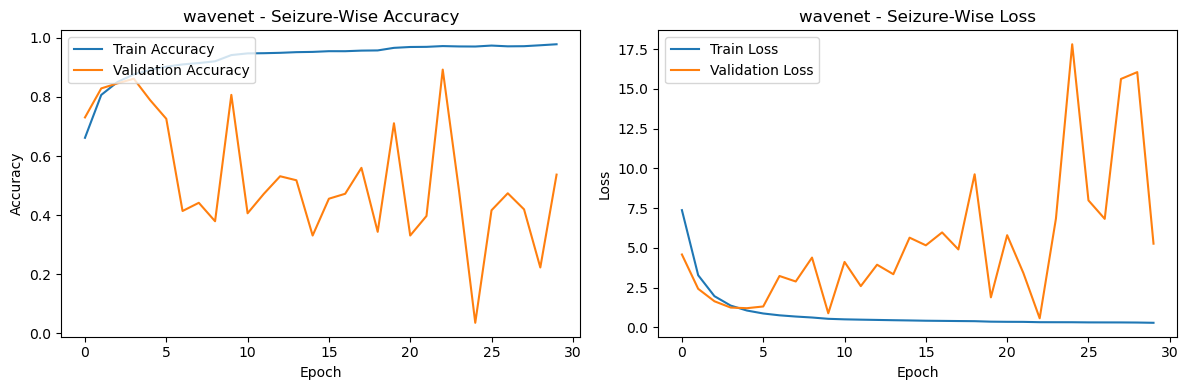


Plotting seizure-wise results for model: bilstm


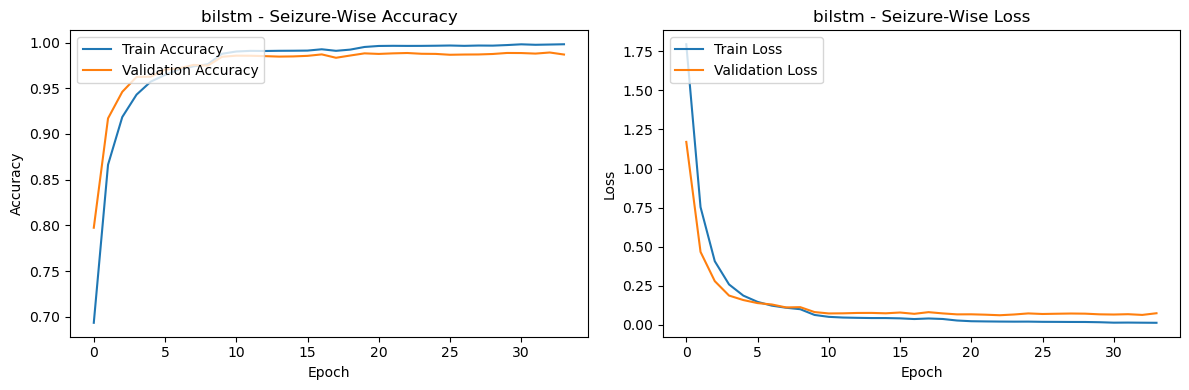


Plotting seizure-wise results for model: bilstm_attention


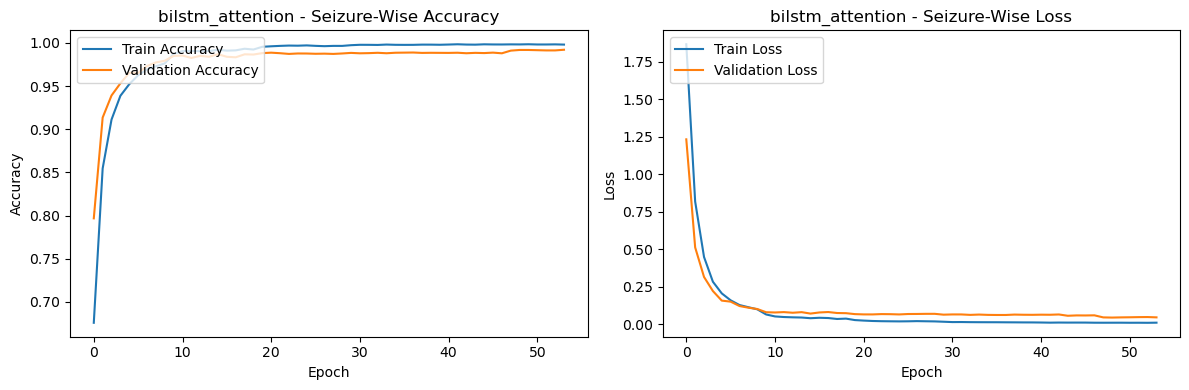


Plotting seizure-wise results for model: wavenet_bilstm_attention


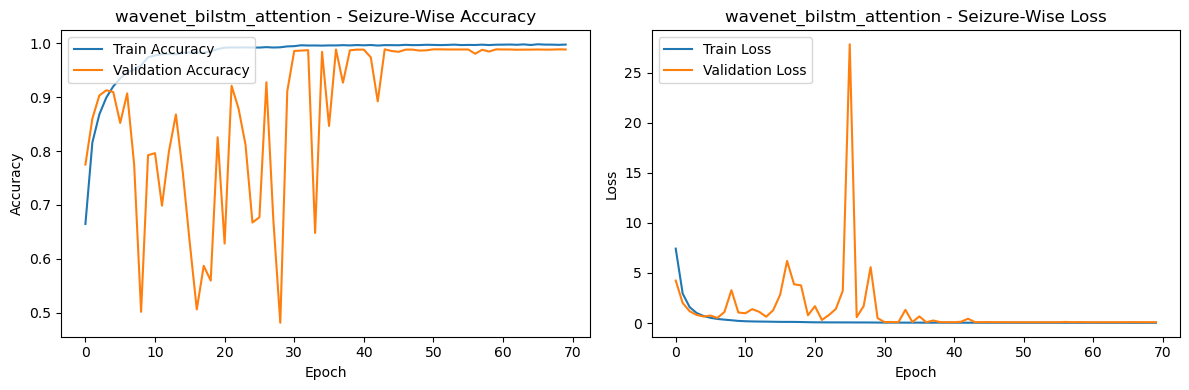

In [22]:
for model_type in model_types:
    print(f"\nPlotting seizure-wise results for model: {model_type}")
    # Load history
    history_file = f'history_{model_type}_seizure_wise.pkl'
    with open(history_file, 'rb') as f:
        data = pickle.load(f)
        avg_history = data['history']


    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(avg_history['accuracy'], label='Train Accuracy')
    plt.plot(avg_history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} - Seizure-Wise Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(avg_history['loss'], label='Train Loss')
    plt.plot(avg_history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} - Seizure-Wise Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


For patient-wise...


Plotting patient-wise results for model: wavenet


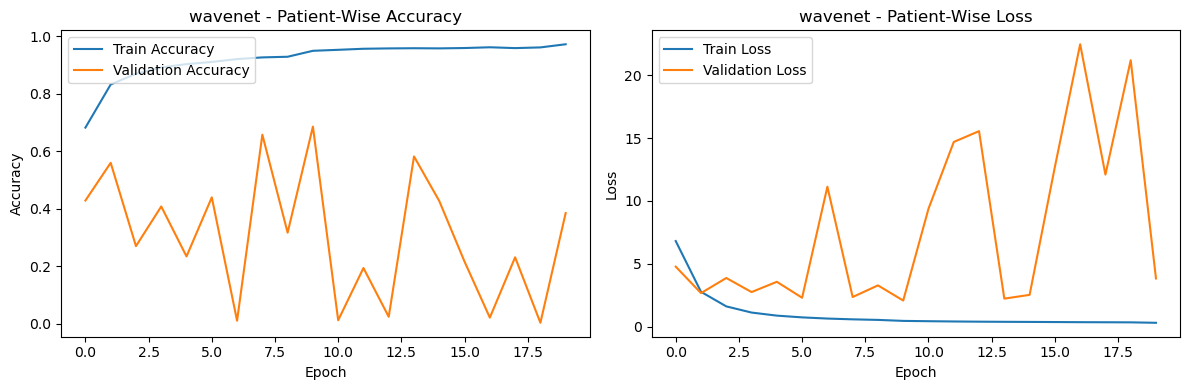


Plotting patient-wise results for model: bilstm


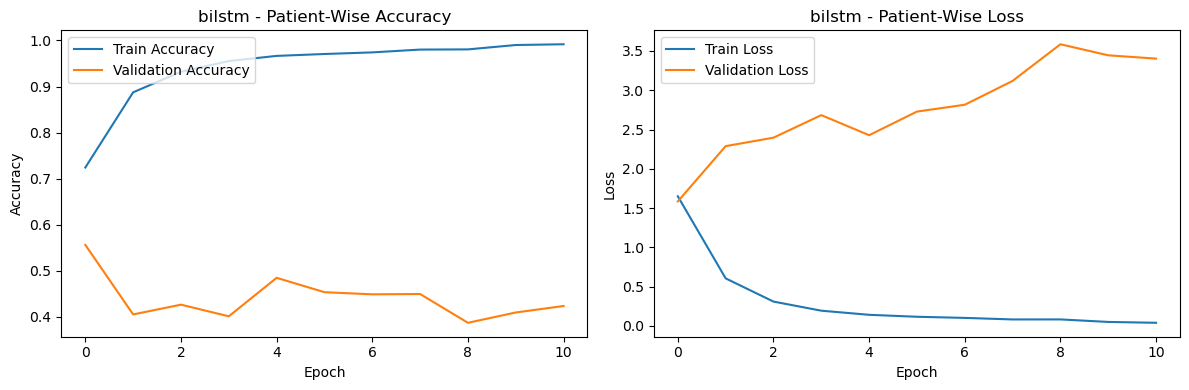


Plotting patient-wise results for model: bilstm_attention


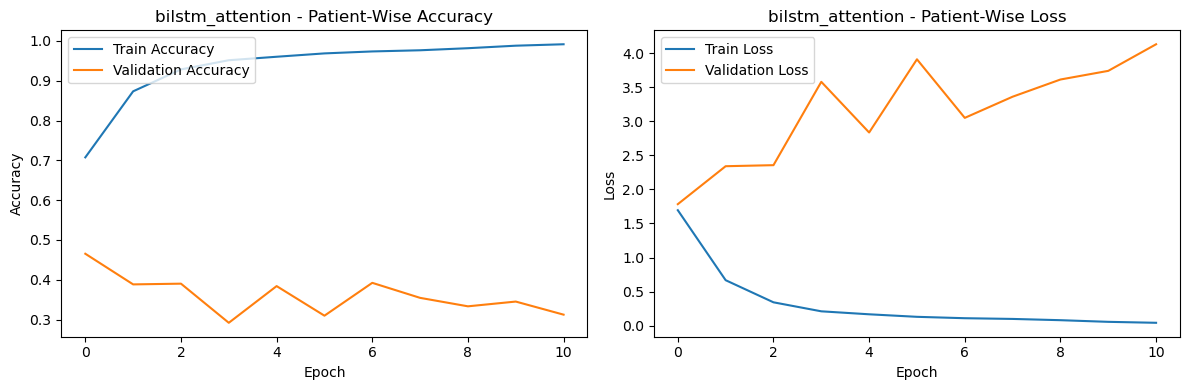


Plotting patient-wise results for model: wavenet_bilstm_attention


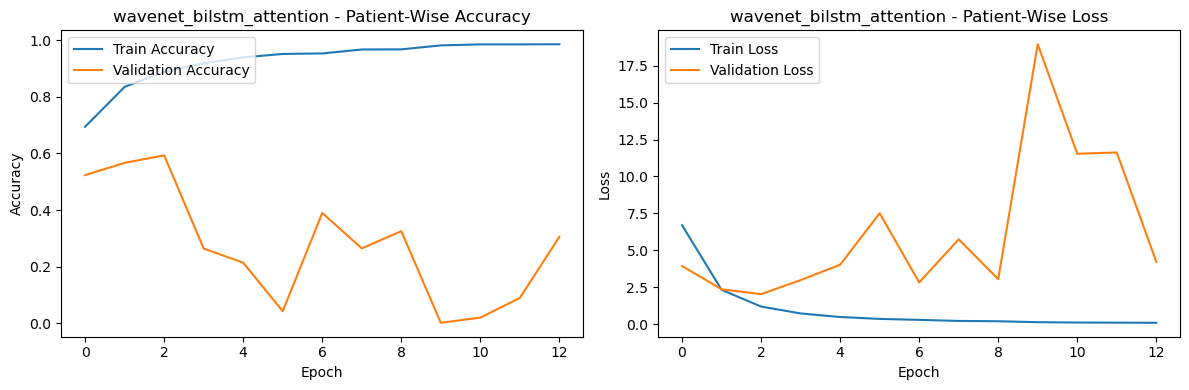

In [23]:
for model_type in model_types:
    print(f"\nPlotting patient-wise results for model: {model_type}")
    # Load history
    history_file = f'history_{model_type}_patient_wise.pkl'
    with open(history_file, 'rb') as f:
        data = pickle.load(f)
        history = data['history']

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} - Patient-Wise Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} - Patient-Wise Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


<a id='CM'></a>
## 2. Confusion Matrix

This next section takes the saved seizure-wise histories and display the normalised confusion matrix of 7-class seizure types.


Plotting seizure-wise confusion matrix for model: wavenet


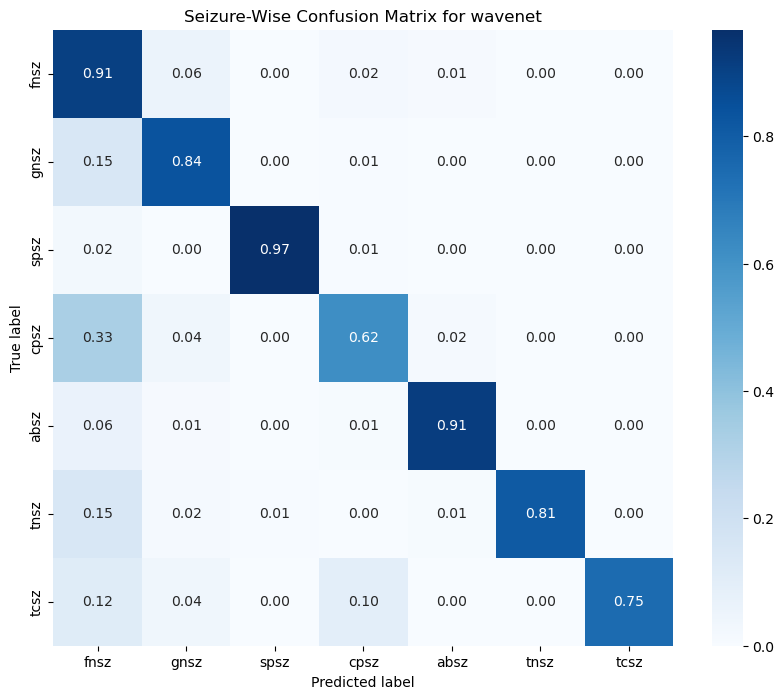


Plotting seizure-wise confusion matrix for model: bilstm


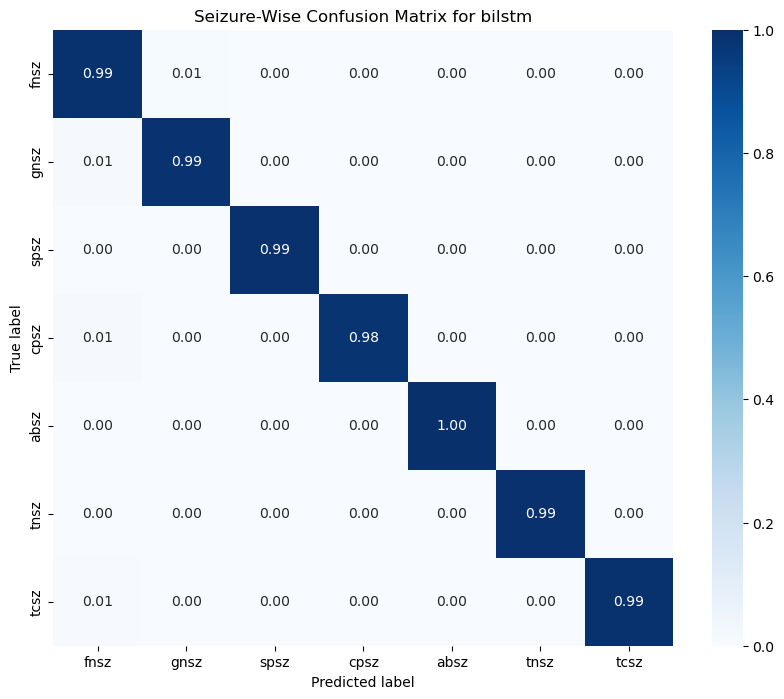


Plotting seizure-wise confusion matrix for model: bilstm_attention


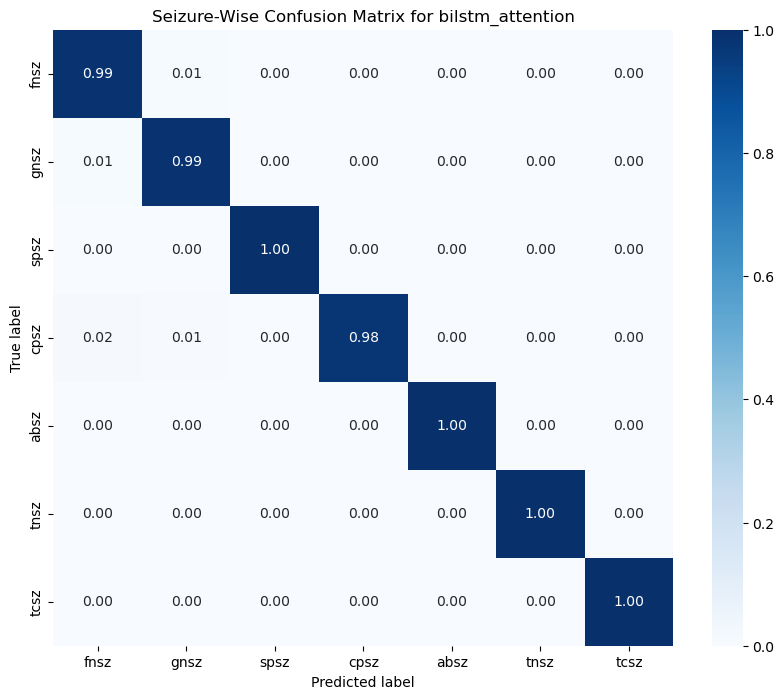


Plotting seizure-wise confusion matrix for model: wavenet_bilstm_attention


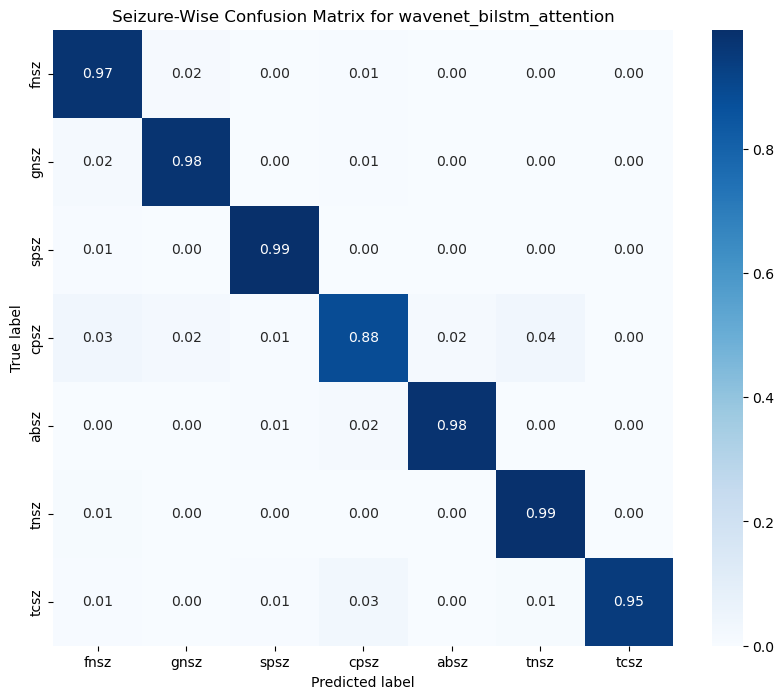

In [24]:
for model_type in model_types:
    print(f"\nPlotting seizure-wise confusion matrix for model: {model_type}")
    
    # Load history and metrics
    history_file = f'history_{model_type}_seizure_wise.pkl'
    with open(history_file, 'rb') as f:
        data = pickle.load(f)
        avg_metrics_seizure = data['metrics']
    
    total_cm_seizure = avg_metrics_seizure.get('confusion_matrix')
    
    if total_cm_seizure is not None:
        # Normalize the confusion matrix
        cm_normalized = total_cm_seizure.astype('float') / total_cm_seizure.sum(axis=1)[:, np.newaxis]
    
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cbar=True, cmap="Blues",
                    xticklabels=EVENT_CLASSES, yticklabels=EVENT_CLASSES)
        plt.title(f'Seizure-Wise Confusion Matrix for {model_type}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


For patient-wise...


Plotting patient-wise confusion matrix for model: wavenet


/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_81486/3046242233.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = conf_matrix_patient.astype('float') / conf_matrix_patient.sum(axis=1)[:, np.newaxis]


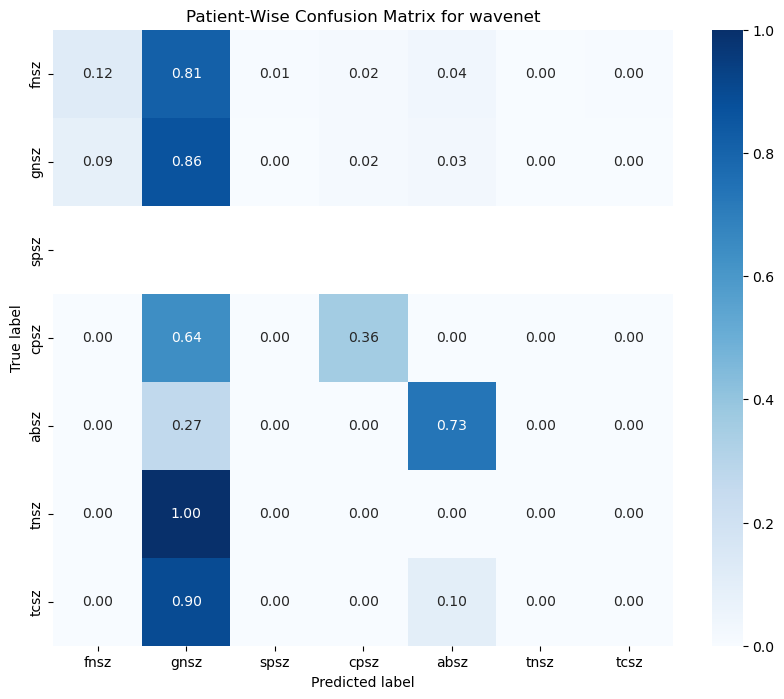


Plotting patient-wise confusion matrix for model: bilstm


/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_81486/3046242233.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = conf_matrix_patient.astype('float') / conf_matrix_patient.sum(axis=1)[:, np.newaxis]


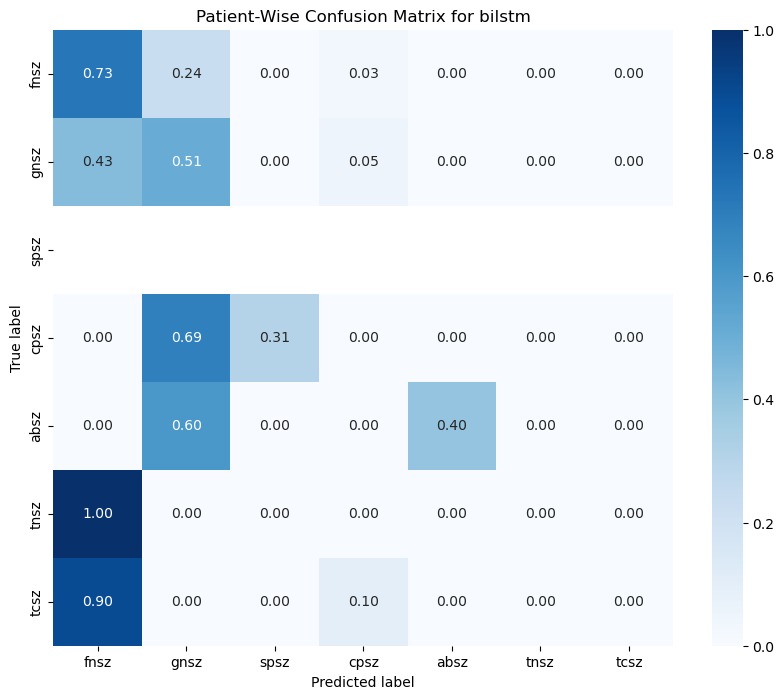


Plotting patient-wise confusion matrix for model: bilstm_attention


/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_81486/3046242233.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = conf_matrix_patient.astype('float') / conf_matrix_patient.sum(axis=1)[:, np.newaxis]


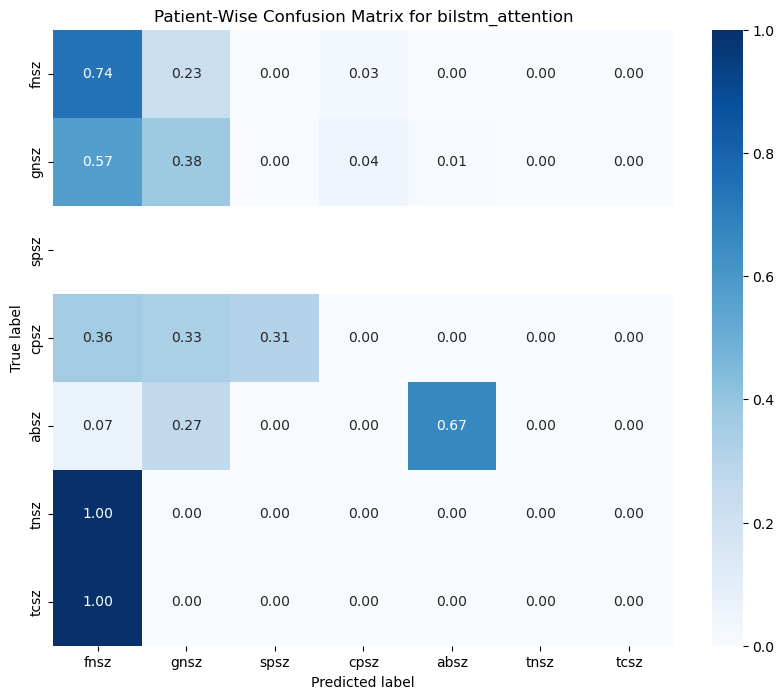


Plotting patient-wise confusion matrix for model: wavenet_bilstm_attention


/var/folders/73/741h2hzd4k93zpm_pwxjrwm40000gn/T/ipykernel_81486/3046242233.py:13: RuntimeWarning: invalid value encountered in divide
  cm_normalized = conf_matrix_patient.astype('float') / conf_matrix_patient.sum(axis=1)[:, np.newaxis]


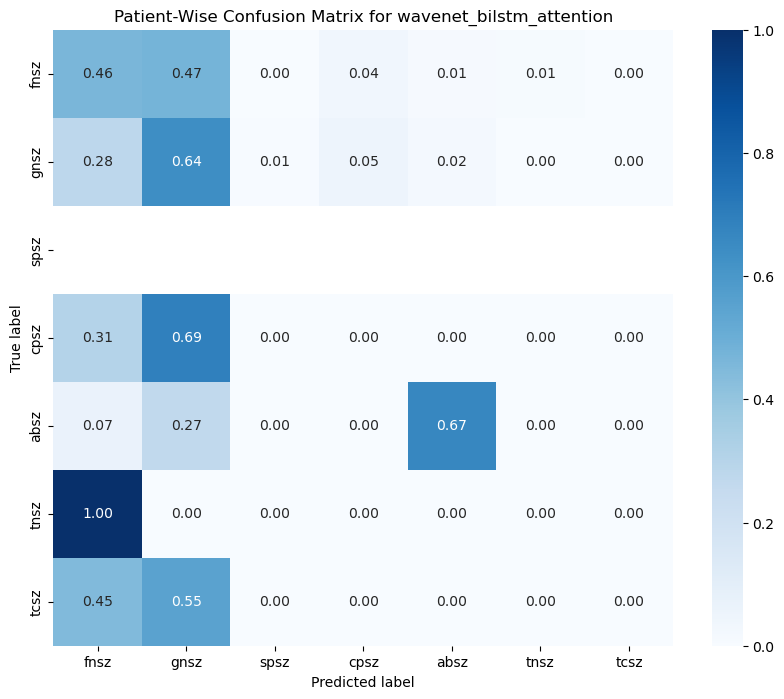

In [25]:
for model_type in model_types:
    print(f"\nPlotting patient-wise confusion matrix for model: {model_type}")
    # Load history and metrics
    history_file = f'history_{model_type}_patient_wise.pkl'
    with open(history_file, 'rb') as f:
        data = pickle.load(f)
        metrics_patient = data['metrics']
    
    conf_matrix_patient = metrics_patient.get('confusion_matrix')
    
    if conf_matrix_patient is not None:
        # Normalize the confusion matrix
        cm_normalized = conf_matrix_patient.astype('float') / conf_matrix_patient.sum(axis=1)[:, np.newaxis]
    
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cbar=True, cmap="Blues",
                    xticklabels=EVENT_CLASSES, yticklabels=EVENT_CLASSES)
        plt.title(f'Patient-Wise Confusion Matrix for {model_type}')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


We print out the other performance metrics

In [26]:
# Create DataFrames for metrics
import pandas as pd

# Seizure-Wise Metrics
df_seizure = pd.DataFrame.from_dict(seizure_wise_metrics, orient='index')
print("\nSeizure-Wise Metrics:")
print(df_seizure)

# Patient-Wise Metrics
df_patient = pd.DataFrame.from_dict(patient_wise_metrics, orient='index')
print("\nPatient-Wise Metrics:")
print(df_patient)



Seizure-Wise Metrics:
                          f1_score  accuracy  precision    recall  \
wavenet                   0.852999  0.856880   0.894642  0.856880   
bilstm                    0.988235  0.988237   0.988251  0.988237   
bilstm_attention          0.988749  0.988750   0.988763  0.988750   
wavenet_bilstm_attention  0.967808  0.967484   0.971921  0.967484   

                          sensitivity  specificity  \
wavenet                      0.828537     0.967500   
bilstm                       0.990882     0.997380   
bilstm_attention             0.992714     0.997516   
wavenet_bilstm_attention     0.962084     0.993634   

                                                           confusion_matrix  
wavenet                   [[7550, 487, 0, 158, 112, 0, 8], [1019, 5508, ...  
bilstm                    [[8222, 66, 1, 19, 2, 1, 4], [90, 6489, 0, 4, ...  
bilstm_attention          [[8213, 70, 5, 23, 0, 2, 2], [75, 6503, 0, 5, ...  
wavenet_bilstm_attention  [[8095, 125, 9, 61, 9,

### Load Keras models and View .summary()

In [2]:
from tensorflow.keras.models import load_model

# List of model types to load
model_types = ['wavenet', 'bilstm', 'bilstm_attention', 'wavenet_bilstm_attention']

# Loop over each model type
for model_type in model_types:
    model_file = f'model_{model_type}.h5'
    # Load the model
    print(f"\nLoading model from file: {model_file}")
    if model_type in ['bilstm_attention', 'wavenet_bilstm_attention']:
        model = load_model(model_file, custom_objects={'ChannelWiseAttention': ChannelWiseAttention})
    else:
        model = load_model(model_file)
    
    # Display the model summary
    print(f"\nModel summary for {model_type}:")
    model.summary()



Loading model from file: model_wavenet.h5

Model summary for wavenet:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 22)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 16)      368         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 16)      784         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 256, 16)      784         ['conv1d[0][0]']                 
                       

NameError: name 'ChannelWiseAttention' is not defined